音声のAI

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
!pip install librosa

In [30]:
!pip install livelossplot

In [31]:
!pip install py-feat

In [32]:
#表情系
import os
import subprocess
import glob
from feat import Detector
from feat.plotting import imshow
#音声系
import librosa
import numpy as np
#音声のAI用
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from keras import regularizers
#グラフ系
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch

In [33]:
files = [
    '/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/*/*/*JOY?.wav',
    '/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/*/*/*ACC?.wav',
    '/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/*/*/*FEA?.wav',
    '/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/*/*/*SUR?.wav',
    '/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/*/*/*SAD?.wav',
    '/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/*/*/*DIS?.wav',
    '/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/*/*/*ANG?.wav',
    '/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/*/*/*ANT?.wav',
]
#入力データ2656個
#/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/F1/A/FOY0101ANT0.wav

In [21]:
# メルスペクトログラムを計算する関数
def compute_mel_spectrogram(audio_data):
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# データの前処理
dataset = []
label = []
for i, f in enumerate(files):
    for wav in glob.glob(f):
        audio_data, sr = librosa.load(wav)
        mel_spec = compute_mel_spectrogram(audio_data)
        dataset.append(mel_spec.T)
        label.append(i)

dataset = pad_sequences(dataset, padding='post') #最大フレームに合わせて0埋めしてくれる（シーケンス長をそろえる）
dataset = np.array(dataset,dtype=np.float)
label = np.array(label)

dataset.shape

<ipython-input-21-54413d419fd8>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataset = np.array(dataset,dtype=np.float)


(2656, 353, 128)

In [22]:
# ラベルをone-hotエンコーディング
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(label)
label_one_hot = to_categorical(label_encoded)

# データを訓練用とテスト用に分割
train_data, test_data, train_label, test_label = train_test_split(dataset, label_one_hot, test_size=0.2)

train_data /= 255.0
test_data /= 255.0
train_data.shape
train_data

array([[[-0.18823529, -0.17647059, -0.2       , ..., -0.31372549,
         -0.31372549, -0.31372549],
        [-0.18431373, -0.16862745, -0.19607843, ..., -0.31372549,
         -0.31372549, -0.31372549],
        [-0.18039216, -0.16078431, -0.2       , ..., -0.31372549,
         -0.31372549, -0.31372549],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.19215686, -0.17647059, -0.19607843, ..., -0.31372549,
         -0.31372549, -0.31372549],
        [-0.19215686, -0.16078431, -0.2       , ..., -0.31372549,
         -0.31372549, -0.31372549],
        [-0.18431373, -0.16078431, -0.20392157, ..., -0.31372549,
         -0.31372549, -0.31372549],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [34]:
model = Sequential([
    Reshape((353,128,1), input_shape=train_data.shape[1:]),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(8, activation='softmax')  # クラスの数に応じて調整
])

# モデルのコンパイルと学習
optimizer = Adam(learning_rate=0.001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
epoch = 20
history = model.fit(train_data, train_label, epochs=epoch, validation_data=(test_data, test_label))

Epoch 1/20
67/67 [==============================] - 192s 3s/step - loss: 2.0711 - accuracy: 0.1846 - val_loss: 2.0338 - val_accuracy: 0.2086
Epoch 2/20
67/67 [==============================] - 176s 3s/step - loss: 2.0205 - accuracy: 0.2090 - val_loss: 2.0126 - val_accuracy: 0.1917
Epoch 3/20
67/67 [==============================] - 183s 3s/step - loss: 1.9891 - accuracy: 0.2100 - val_loss: 2.0016 - val_accuracy: 0.1936
Epoch 4/20
67/67 [==============================] - 194s 3s/step - loss: 1.9725 - accuracy: 0.2312 - val_loss: 1.9862 - val_accuracy: 0.2068
Epoch 5/20
67/67 [==============================] - 188s 3s/step - loss: 1.9209 - accuracy: 0.2500 - val_loss: 1.9448 - val_accuracy: 0.2274
Epoch 6/20
67/67 [==============================] - 188s 3s/step - loss: 1.8793 - accuracy: 0.2754 - val_loss: 1.9155 - val_accuracy: 0.2481
Epoch 7/20
67/67 [==============================] - 191s 3s/step - loss: 1.7865 - accuracy: 0.3310 - val_loss: 1.8705 - val_accuracy: 0.2650
Epoch 8/20
67

KeyboardInterrupt: ignored

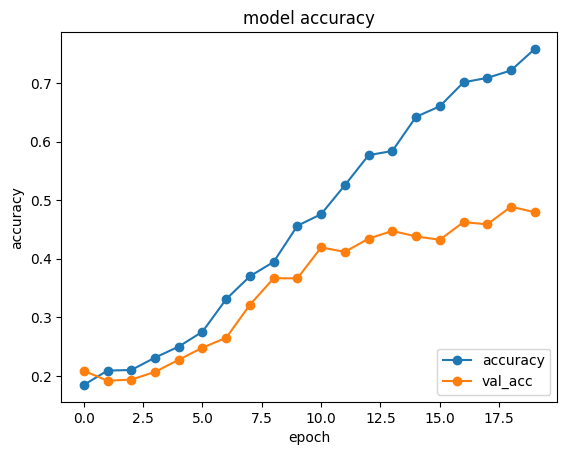

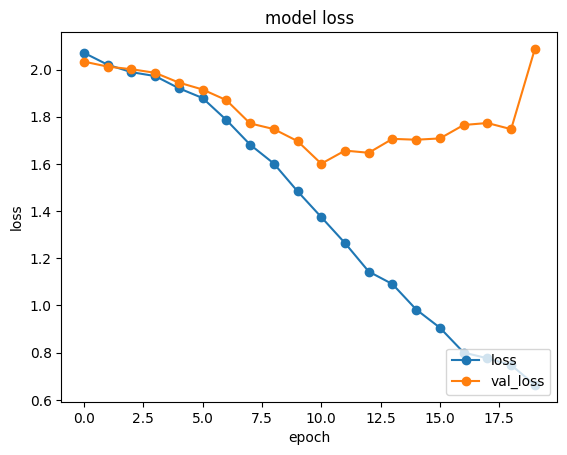

In [ ]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

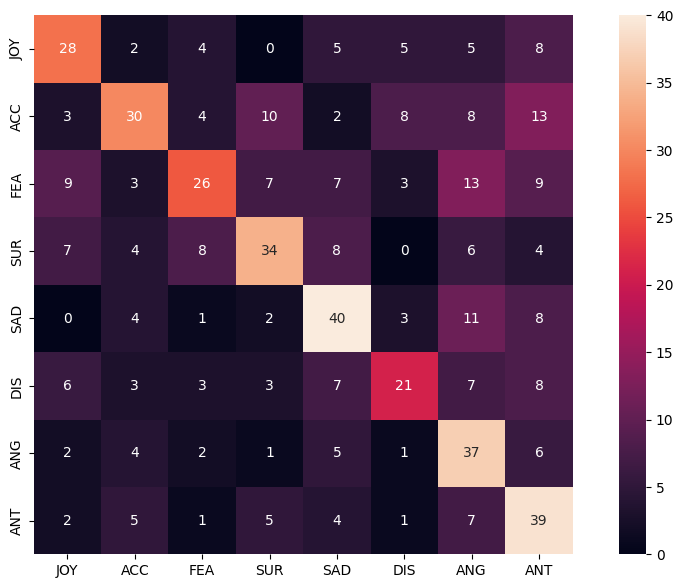

In [ ]:
emotionCategory = {"JOY": 0, "ACC": 1, "FEA": 2,"SUR": 3, "SAD": 4,"DIS": 5, "ANG": 6,"ANT": 7}
x = np.array(test_data,dtype=np.float64)
predict_classes = model(x).cpu().numpy().argmax(-1)
cmx_data = confusion_matrix(test_label.argmax(-1), predict_classes)
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize = (12,7))
sn.heatmap(df_cmx, annot=True, fmt='g' ,square = True,yticklabels=emotionCategory,xticklabels=emotionCategory)
plt.show()

印象学習

In [ ]:
impressionFile = "/content/gdrive/MyDrive/ai_impression_data.csv"
imp_csv = pd.read_csv(impressionFile, encoding="utf-8")
imp_csv

,anger,disgust,fear,happiness,sadness,surprise,neutral,JOY,ACC,FEA,SUR,SAD,DIS,ANG,ANT,label
0,0.148579,0.040517,0.006999,0.071102,0.003567,0.299910,0.429326,0.140603,0.027781,0.104579,0.002879,0.218473,0.036124,0.008997,0.460564,1
1,0.057873,0.012664,0.092213,0.074379,0.024625,0.176347,0.561899,0.000906,0.037596,0.005635,0.002861,0.831537,0.046214,0.036963,0.038287,1
2,0.041093,0.019007,0.027897,0.462881,0.028863,0.097358,0.322902,0.000006,0.000000,0.000000,0.000000,0.999331,0.000660,0.000001,0.000001,1
3,0.048412,0.017937,0.036238,0.063754,0.128989,0.078351,0.626321,0.000387,0.000000,0.000000,0.000000,0.999590,0.000000,0.000000,0.000022,1
4,0.138873,0.040290,0.029781,0.015649,0.198785,0.013418,0.563205,0.000028,0.000669,0.000000,0.000000,0.995958,0.000761,0.002063,0.000521,1
5,0.213839,0.003198,0.008477,0.040825,0.065546,0.030684,0.637432,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1
6,0.162679,0.022069,0.023253,0.029427,0.112683,0.062590,0.587298,0.000002,0.000000,0.000000,0.000000,0.999964,0.000000,0.000000,0.000034,1
7,0.069611,0.051738,0.074835,0.035180,0.205553,0.018416,0.544668,0.037925,0.000000,0.000000,0.000000,0.960395,0.000453,0.000000,0.001228,1
8,0.197435,0.010772,0.013929,0.121372,0.001830,0.156245,0.498417,0.002101,0.000000,0.000020,0.000000,0.996272,0.000087,0.000000,0.001519,2
9,0.114778,0.005798,0.092531,0.062845,0.010428,0.391953,0.321665,0.000024,0.009955,0.000293,0.000224,0.783128,0.100345,0.100934,0.005097,2


In [109]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#データ分離
y = imp_csv.loc[:,"label"]
x = imp_csv.loc[:,["anger","disgust","fear","happiness","sadness","surprise","neutral","JOY","ACC","FEA","SUR","SAD","DIS","ANG","ANT"]]

# 学習用とテスト用に分離する
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size = 0.3, train_size = 0.7, shuffle = True)

# 学習する
clf = SVC()
clf.fit(x_train, y_train)

SVC()

In [110]:
# 評価する
y_pred = clf.predict(x_test)
print("正解率 = ", accuracy_score(y_test, y_pred))

正解率 =  0.42857142857142855


動画入力

In [111]:
src_img_dir = "/content/gdrive/My Drive/videoexp/src_img"
src_wav_dir = "/content/gdrive/My Drive/videoexp/src_wav"
#↓動画変更時は必ず入力
movie_path = "/content/2-E.mp4"

In [112]:
import shutil
if os.path.exists(movie_path):
  if not os.path.exists(src_img_dir):
    os.makedirs(src_img_dir)

  #ディレクトリの中身をリセット
  try:
      shutil.rmtree(src_img_dir)
  except FileNotFoundError:
      pass
  #同名のフォルダを作成する
  os.mkdir(src_img_dir)



#動画をjpgにする
  cmd_m = [
    'ffmpeg',
    '-i',
    movie_path,
    '-vf',
    'fps=1',
    f'{src_img_dir}/%04d.jpg'
  ]
  subprocess.call(cmd_m)


if os.path.exists(movie_path):
  if not os.path.exists(src_wav_dir):
    os.makedirs(src_wav_dir)

  try:
      shutil.rmtree(src_wav_dir)
  except FileNotFoundError:
      pass
  #同名のフォルダを作成する
  os.mkdir(src_wav_dir)

#動画をwavにする
  cmd_w = [
    'ffmpeg',
    '-i',
    movie_path,
    '-vn',
    '-acodec',
    'pcm_s16le',
    '-ac',
    '1',
    '-ar',
    '44100',
    f'{src_wav_dir}/output.wav'
  ]
  subprocess.call(cmd_w)

In [113]:
import glob

src_img_files = glob.glob("{}/*.jpg".format(src_img_dir))
src_img_files.sort()

print(len(src_img_files), "image files") #動画を画像にして取得する処理

9 image files


表情系

In [114]:
face_model = "retinaface"
landmark_model = "mobilenet"
au_model = "xgb"
emotion_model = "resmasknet"
facepose_model = "img2pose"
detector = Detector(
    face_model=face_model,
    landmark_model=landmark_model,
    au_model=au_model,
    emotion_model=emotion_model,
    facepose_model = facepose_model
)

100%|██████████| 176/176 [00:00<00:00, 181553.74it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


In [115]:
detector
#ここで画像をリストに入れる（何枚画像があるかわかったり顔認識するときに便利）
files = os.listdir(src_img_dir)
print(files)

['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg']


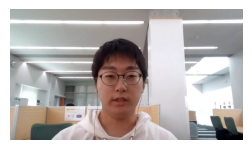

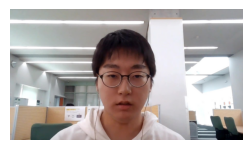

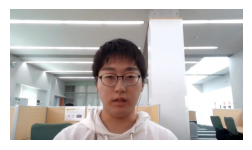

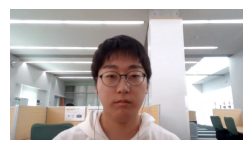

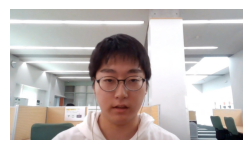

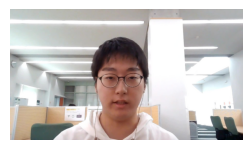

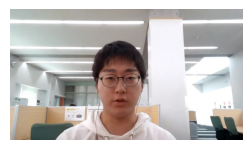

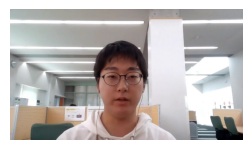

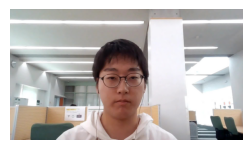

In [116]:
single_face_img_path = src_img_files
for i in range(len(files)):
  imshow(single_face_img_path[i])

In [117]:
single_face_prediction = detector.detect_image(single_face_img_path)
single_face_prediction.emotions

100%|██████████| 9/9 [01:07<00:00,  7.49s/it]


,anger,disgust,fear,happiness,sadness,surprise,neutral
0,0.003500,0.000016,0.001792,0.000235,0.005194,0.453830,0.535433
1,0.001034,0.000021,0.000307,0.000125,0.013619,0.118086,0.866810
2,0.000408,0.000249,0.000851,0.000190,0.011176,0.134090,0.853036
3,0.000341,0.000005,0.000030,0.000142,0.008630,0.003949,0.986902
4,0.000393,0.000029,0.000063,0.000502,0.003216,0.019146,0.976651
5,0.003724,0.000049,0.001289,0.000771,0.005836,0.320742,0.667589
6,0.005786,0.000398,0.002731,0.000498,0.012999,0.292836,0.684751
7,0.000978,0.000023,0.002331,0.000654,0.006298,0.057205,0.932511
8,0.002229,0.000024,0.000111,0.000048,0.032706,0.014146,0.950736


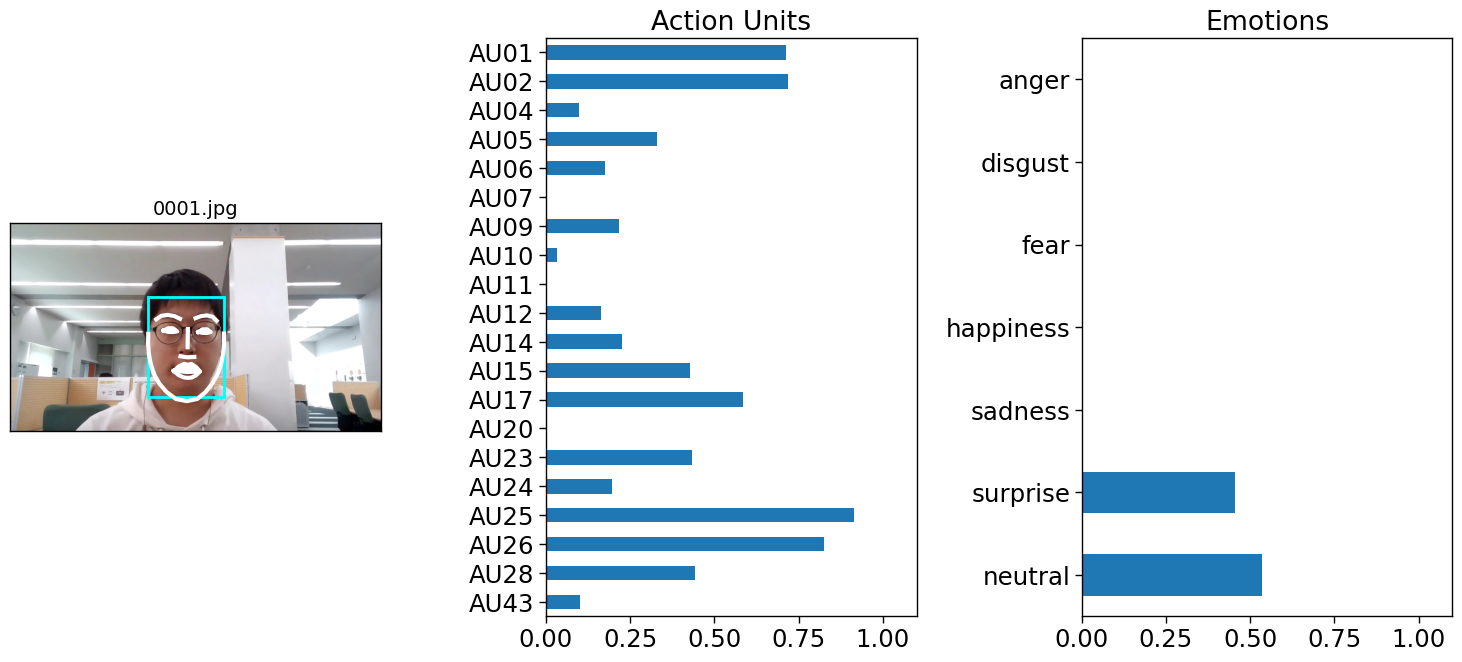

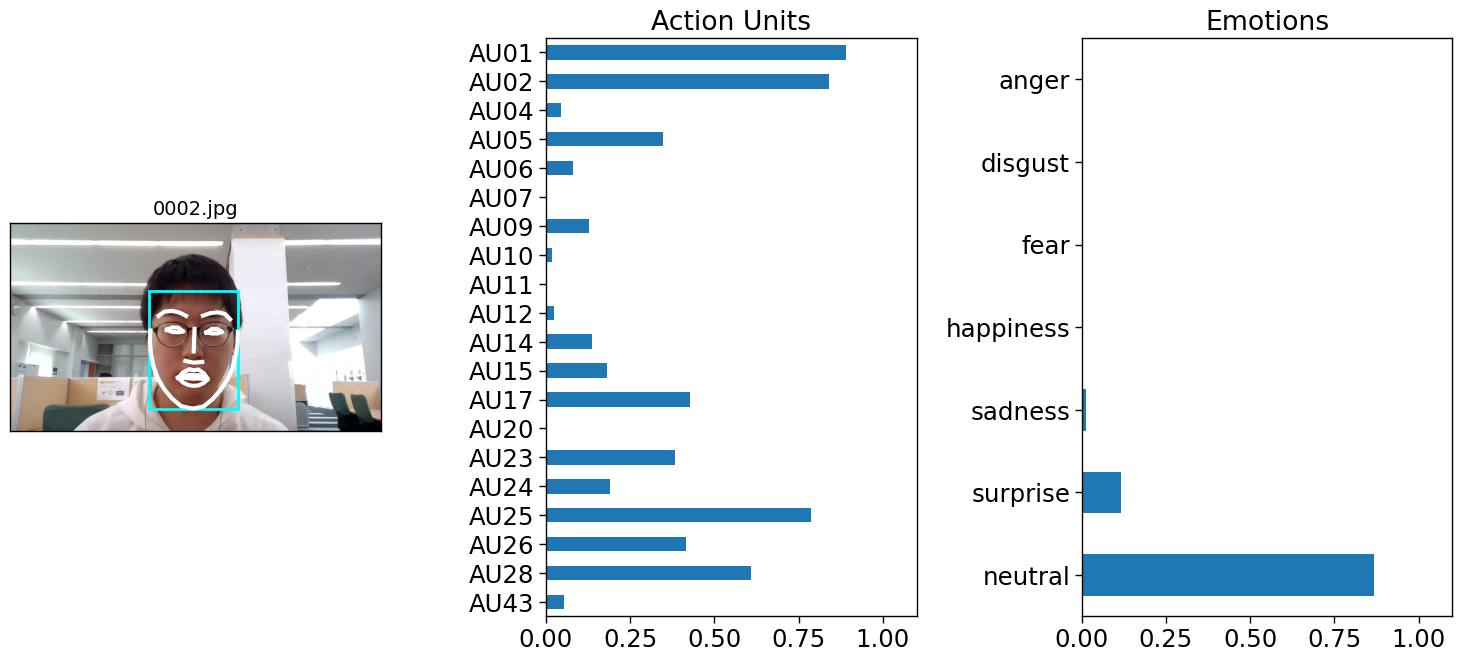

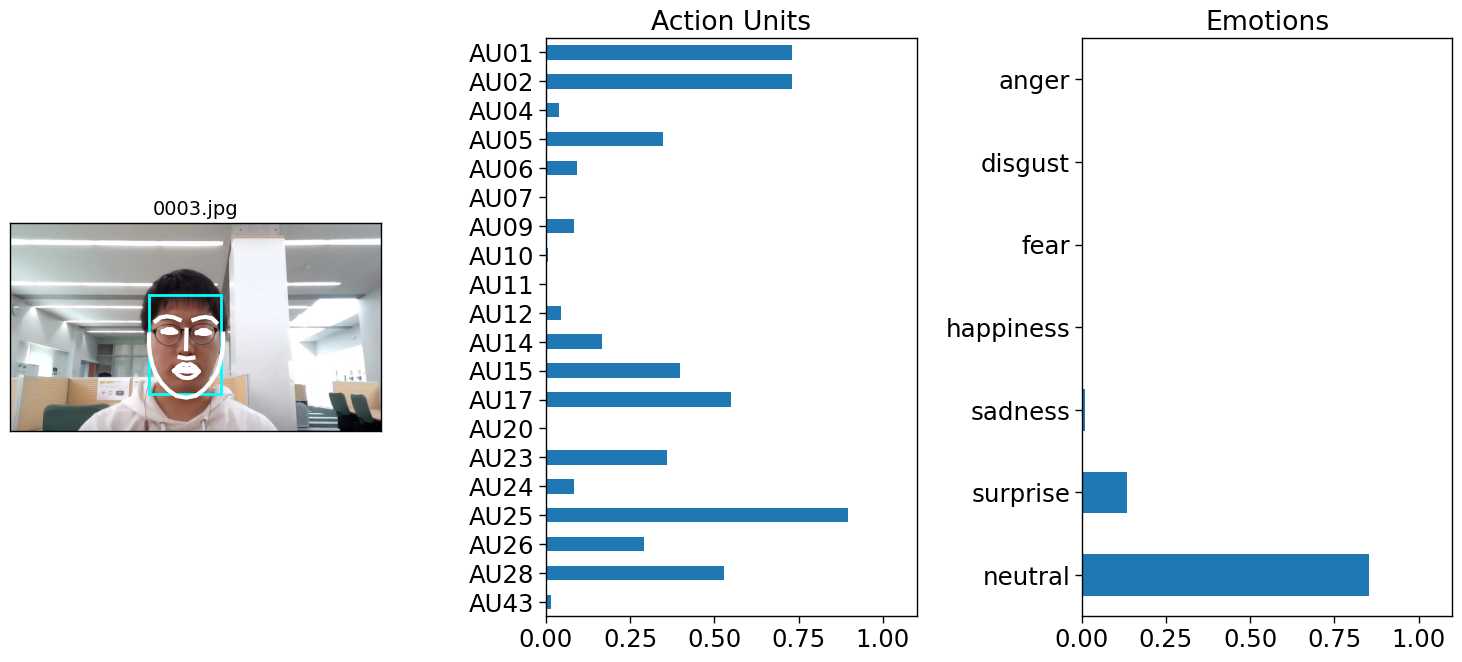

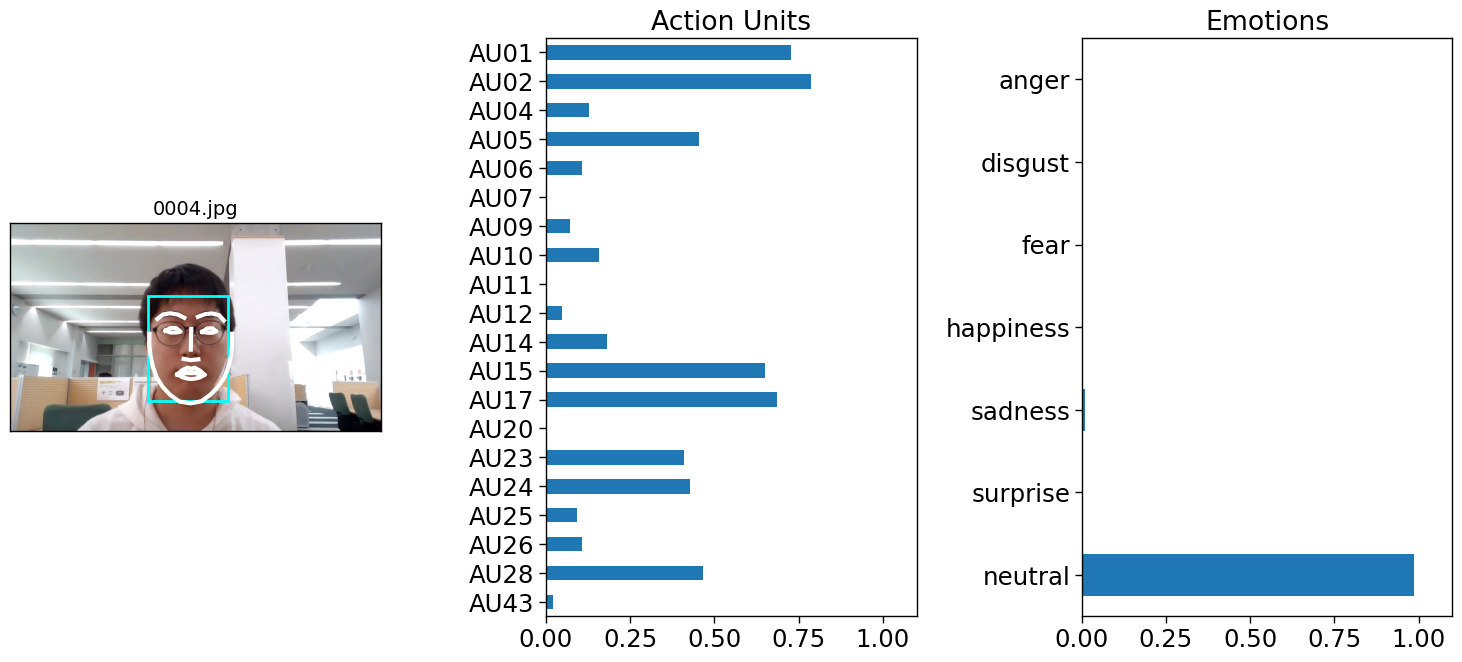

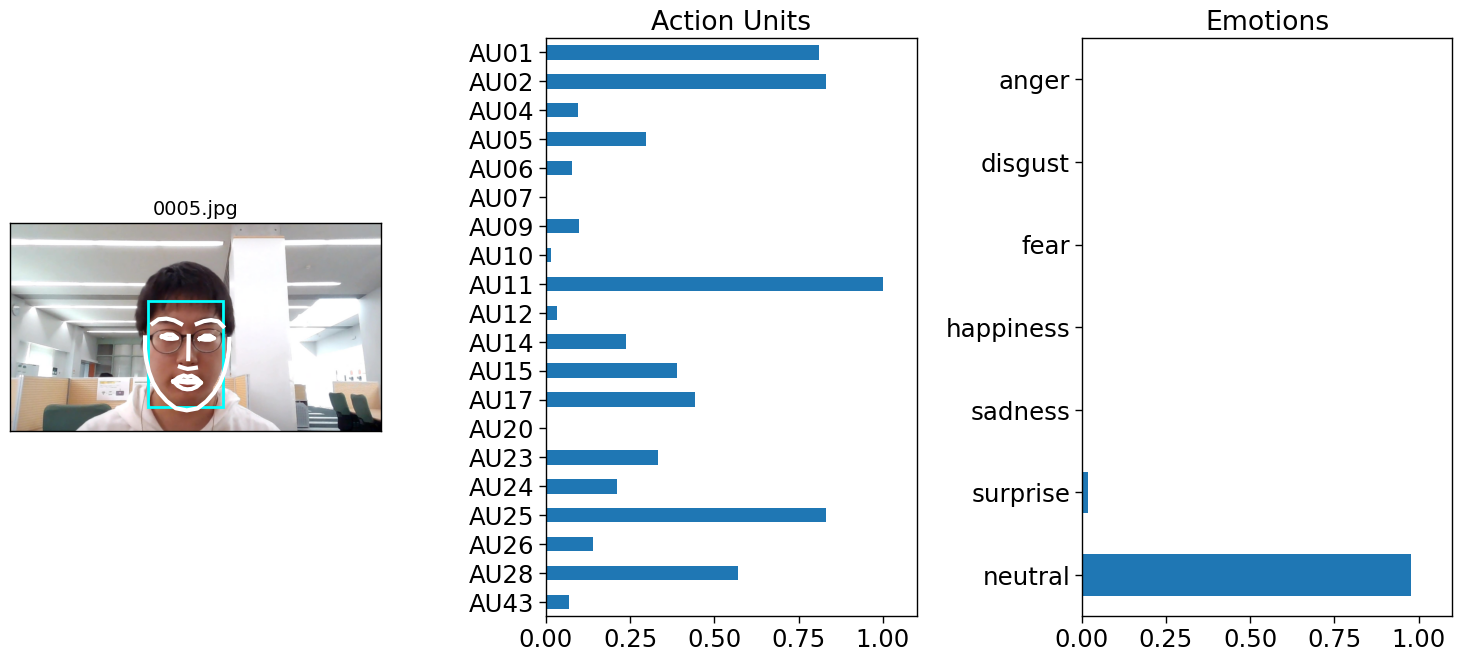

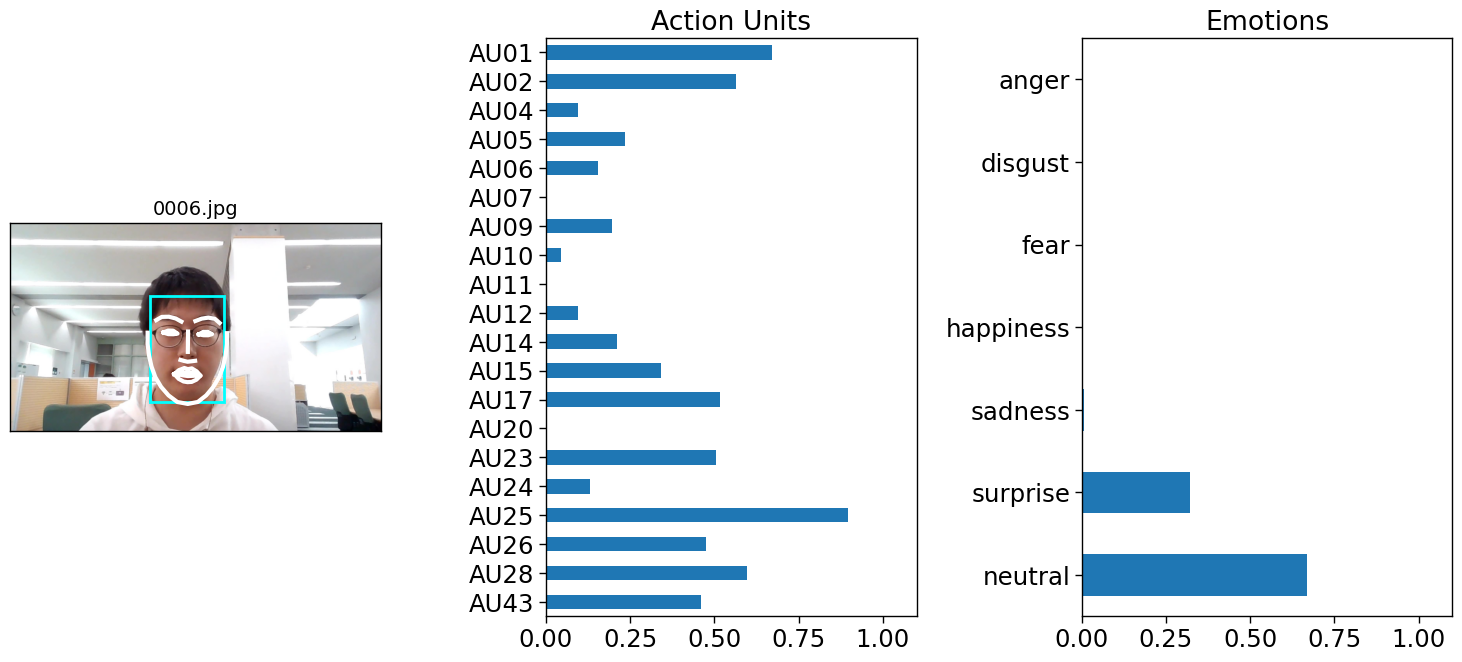

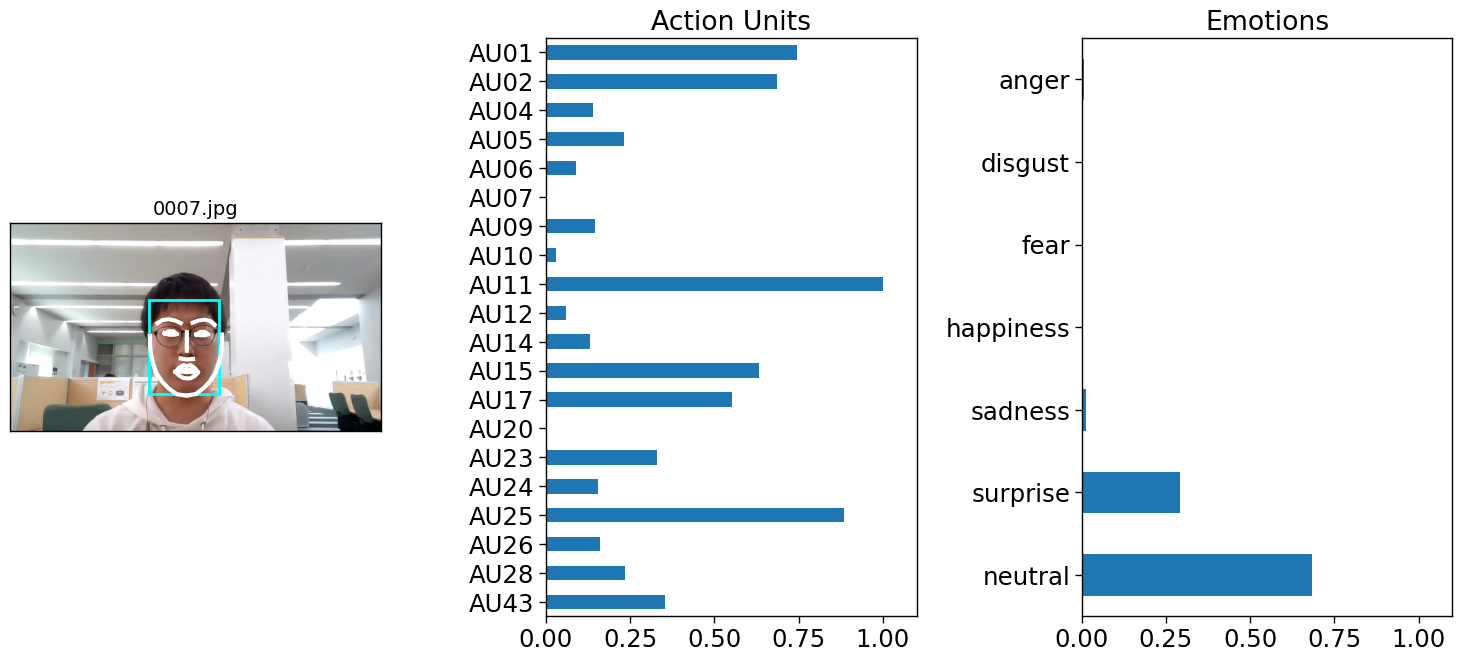

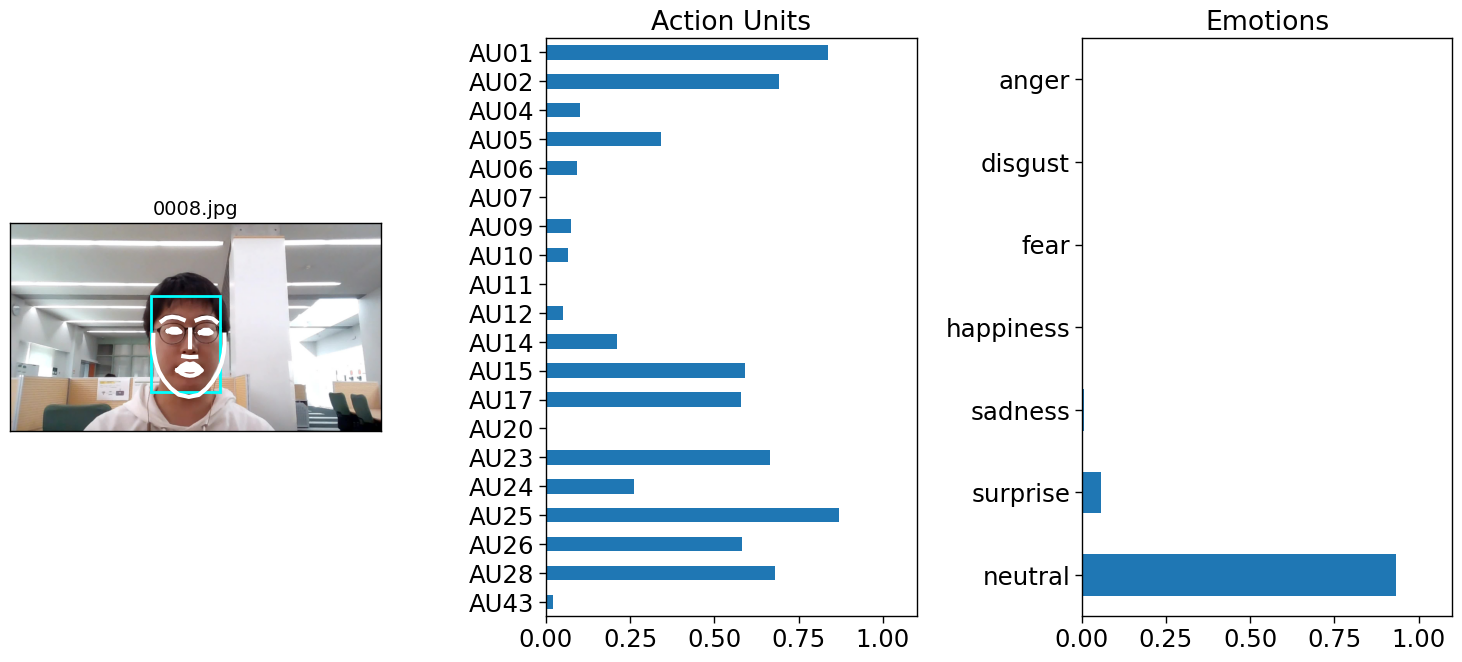

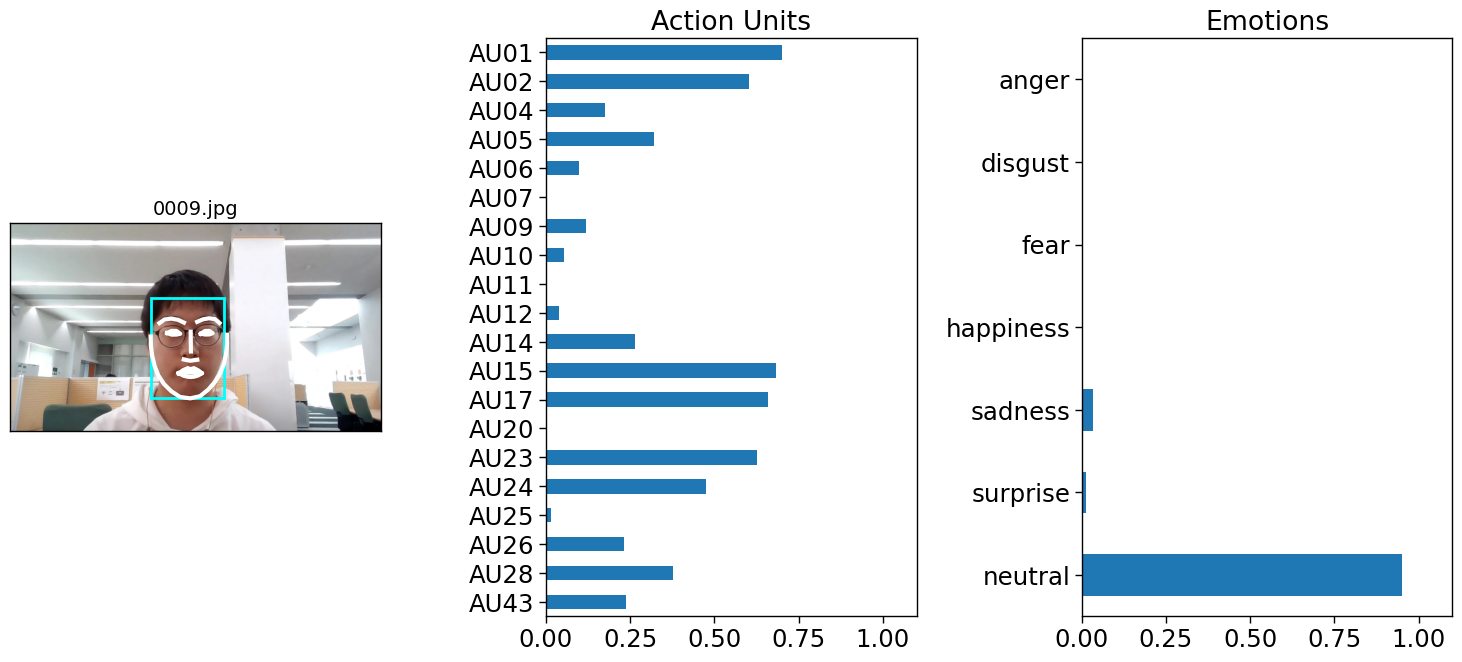

In [118]:
figs = single_face_prediction.plot_detections()

推定結果

In [119]:
#表情の数値平均
single_face_prediction.emotions.mean()

anger        0.002044
disgust      0.000090
fear         0.001056
happiness    0.000352
sadness      0.011075
surprise     0.157114
neutral      0.828269
dtype: float32

In [120]:
# 音声ファイルを読み込み、特徴量を抽出する
audio_file = "/content/gdrive/MyDrive/videoexp/src_wav/output.wav"
audio_data, sr = librosa.load(audio_file)
mel = compute_mel_spectrogram(audio_data)
# 特徴量の長さを353に揃える
mel = pad_sequences([mel.T], maxlen=353, padding='post')
mel = np.array(mel,dtype=np.float64)
mel /= 255.0
#/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/F1/B/FYN0103ANG2.wav
#/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/F2/B/FOY0102DIS3.wav
#/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/F1/B/FYN0707JOY3.wav
#/content/gdrive/MyDrive/OGVC_Vol2/Acted/wav/F1/B/FYN0606SAD0.wav

# モデルに入力し、予測結果を得る
result = model.predict(mel)
#neutral/calm/happy/sad/angry/fearful/disgust/surprise
emotions = ['JOY:喜び','ACC:受容','FEA:恐れ','SUR:驚き','SAD:悲しみ','DIS:嫌悪','ANG:怒り','ANT:期待']
prelabel = np.argmax(result, axis=1)
print(result)
print(emotions[int(prelabel)])

1/1 [==============================] - 0s 275ms/step
[[0.14541048 0.09332992 0.12736668 0.09935091 0.15428782 0.11433113
  0.13784201 0.12808108]]
SAD:悲しみ


フィードバック表示

In [121]:
dfFace = pd.DataFrame(single_face_prediction.emotions.mean()).T
dfVoice = pd.DataFrame(model.predict(mel)).set_axis(['JOY', 'ACC', 'FEA','SUR','SAD','DIS','ANG','ANT'], axis=1)

pd.options.display.float_format = '{:.6f}'.format
dfFV = pd.concat([dfFace, dfVoice], axis=1)
dfFV

1/1 [==============================] - 0s 62ms/step


,anger,disgust,fear,happiness,sadness,surprise,neutral,JOY,ACC,FEA,SUR,SAD,DIS,ANG,ANT
0,0.002044,0.000090,0.001056,0.000352,0.011075,0.157114,0.828269,0.145410,0.093330,0.127367,0.099351,0.154288,0.114331,0.137842,0.128081


In [122]:
#印象のラベル
x_FV = dfFV.loc[:,["anger","disgust","fear","happiness","sadness","surprise","neutral","JOY","ACC","FEA","SUR","SAD","DIS","ANG","ANT"]]
y_pred = clf.predict(x_FV)
y_pred

array([3])

In [123]:
#表情のラベル
lsFace = dfFace.values.tolist()
faceLabel = np.argmax(lsFace, axis=1)
faceLabel

array([6])

In [124]:
#声のラベル
prelabel

array([4])

In [126]:
#印象の文
impStr = ["全体的な印象はあまりよくないように見えます。",
           "全体的な印象は少し良くないように見えます。",
           "全体的な印象は少し良く見えます。",
           "全体的な印象は良く見えます。"]
#表情の文
faceStr = ["あなたの表情からは怒りの感情が読み取れます。眉間にしわを寄せたり、目が鋭く細められていたり、口元が引き締まっている可能性があります。",
            "あなたの表情からは嫌悪の感情が読み取れます。眉間にしわを寄せたり、目を不機嫌そうに細めたり、口元を歪ませている可能性があります。",
            "あなたの表情からは恐怖の感情が読み取れます。眉間にしわを寄せ、瞳が大きく見開かれて、緊張している可能性があります。",
            "あなたの表情からは喜びの感情が読み取れます。眉間にしわがなく、口角が上がっていて、リラックスできている可能性があります。",
            "あなたの表情からは悲しみの感情が読み取れます。眉間にしわが寄っていたり、口元が下がっていたりしませんか？",
            "あなたの表情からは驚きの感情が読み取れます。眉間に軽いしわが寄っていたり、瞳が大きく見開かれている可能性があります。",
            "あなたの感情からは何の感情も読み取れません。目、眉、口元に特定の感情の兆候は見当たりません。"]
#声の文
voiceStr = ["あなたの声からは喜んでいるような印象を受け取れます。面接官に対して好印象を与えるでしょう。しかし、その感情が強すぎても逆効果になる恐れがあるので、気を付けましょう。",
             "あなたの声からは受容性が感じられ、面接官からは話しやすさを感じてもらえるでしょう。しかし、面接官のネガティブな発言に対しても受容でいては逆効果になってしまいます。臨機応変な対応を心がけましょう。",
             "あなたの声からは恐れているような感情が受け取れます。緊張で震えたりしていると、そうとらえられてしまいます。一度深呼吸をして落ち着きましょう。",
             "あなたの声は驚いているように聞こえます。少し緊張しているのかもしれません。落ち着いて話しましょう。",
             "あなたからは悲しみの感情が聞き受けられます。声に抑揚がなかったりしていませんか？声のトーンをあげて明るくしましょう。",
             "あなたの声からは嫌悪感が聞き取れます。不愉快な思いなどをしていると面接官に感じ取られたりすると、あまり良い印象を受けないでしょう。今一度、面接だけに集中しましょう。",
             "あなたからは怒りの感情が受け取れます声がとがっていたりすると、怒っているという印象を受けてしまいます。そういった点を意識して、もう少し優しい口調で話しましょう。",
             "あなたからは期待感があるように聞き受けられます。期待通りに進めばよい流れになりますが、期待外れなことが起きると、イライラするなど良くない方向に進んでしまう恐れがあります。適度な期待感で面接に挑みましょう。"]

In [127]:
print(impStr[int(y_pred)-1])
print(faceStr[int(faceLabel)])
print(voiceStr[int(prelabel)])

全体的な印象は少し良く見えます。
あなたの感情からは何の感情も読み取れません。目、眉、口元に特定の感情の兆候は見当たりません。
あなたからは悲しみの感情が聞き受けられます。声に抑揚がなかったりしていませんか？声のトーンをあげて明るくしましょう。
